In [1]:
LMDB_FILEPATH = "/mnt/lab_lmdb/seefood_data"

In [2]:
%load_ext lab_black

In [3]:
%load_ext google.cloud.bigquery
%load_ext line_profiler

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys

sys.path.insert(0, "../..")

In [26]:
import time
import copy

import pandas as pd
import numpy as np
import altair as alt
import lmdb
import pickle

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter
from PIL import Image, ImageFile

from seefood.model import CalorieNet

ImageFile.LOAD_TRUNCATED_IMAGES = True

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [7]:
def get_metrics(name, y_test, y_pred):
    return pd.DataFrame(
        {
            "experiment_name": name,
            "r2_score": [r2_score(y_test, y_pred)],
            "explained_variance_score": [explained_variance_score(y_test, y_pred)],
            "max_error": [max_error(y_test, y_pred)],
            "mean_absolute_error": [mean_absolute_error(y_test, y_pred)],
            "mean_squared_error": [mean_squared_error(y_test, y_pred)],
            "median_absolute_error": [median_absolute_error(y_test, y_pred)],
        }
    )

## Load data

In [10]:
%%bigquery df_nn --project zenscr-seefood-dev

SELECT title, image_path, total_calories
FROM `zenscr-seefood-dev.sparkrecipes.base_filtered`
INNER JOIN `zenscr-seefood-dev.sparkrecipes.image_path`
USING (recipe_id)

In [11]:
df_nn

,title,image_path,total_calories
0,Fruit Cocktail Dessert/Salad,../../data/images/70865/000001,30.0
1,Fruit Cocktail Dessert/Salad,../../data/images/70865/000010,30.0
2,Fruit Cocktail Dessert/Salad,../../data/images/70865/000011,30.0
3,Fruit Cocktail Dessert/Salad,../../data/images/70865/000012,30.0
4,Fruit Cocktail Dessert/Salad,../../data/images/70865/000013,30.0
...,...,...,...
1311732,Banana Bread Muffins,../../data/images/418865/000005,134.9
1311733,Banana Bread Muffins,../../data/images/418865/000006,134.9
1311734,Banana Bread Muffins,../../data/images/418865/000007,134.9
1311735,Banana Bread Muffins,../../data/images/418865/000008,134.9


In [12]:
df_nn.describe()

,total_calories
count,1.311737e+06
mean,2.190868e+02
std,1.085666e+02
min,2.560000e+01
25%,1.350000e+02
50%,2.049000e+02
75%,2.912000e+02
max,5.217000e+02


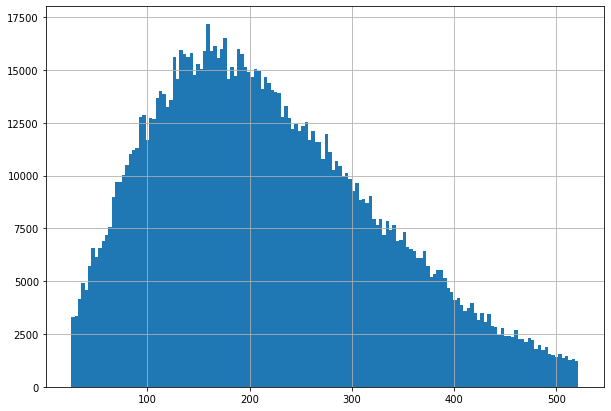

In [13]:
_ = df_nn.total_calories.hist(bins=150, figsize=(10, 7))

# Train Neural Network

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [217]:
IMAGE_SIZE = 224


class SeefoodImage:
    def __init__(self, image, target):
        self.channels = image.shape[2]
        self.size = image.shape[:2]
        self.image = image.tobytes()
        self.target = target

    def get_image(self):
        image = np.frombuffer(self.image, dtype=np.uint8)
        return image.reshape(*self.size, self.channels)


class LMDBDataset(torch.utils.data.Dataset):
    def __init__(self, lmdb_filename, transform=None):
        self.env = lmdb.open(
            lmdb_filename,
            max_readers=8,
            readonly=True,
            lock=False,
            readahead=True,
            meminit=False,
        )
        self.transform = transform
        with self.env.begin(write=False) as txn:
            self.length = txn.stat()["entries"]

    def __getitem__(self, index):
        with self.env.begin(write=False) as txn:
            imgbuf = txn.get(f"{index:08}".encode("ascii"))

        img = pickle.loads(imgbuf)
        pil_img = Image.fromarray(img.get_image())
        if self.transform is not None:
            pil_img = self.transform(pil_img)

        return pil_img, img.target

    def __len__(self):
        return self.length

    def close(self):
        self.env.close()


class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform):
        self.images = X["image_path"].reset_index(drop=True)
        self.y = y.reset_index(drop=True)
        self.transform = transform

        assert self.images.shape[0] == self.y.shape[0]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images.iloc[idx]
        with Image.open(img_path) as f:
            image = f.convert("RGB")
        image = self.transform(image)
        y = self.y.iloc[idx]
        return image, y


data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize(IMAGE_SIZE),
            transforms.CenterCrop(IMAGE_SIZE),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            # transforms.Resize(IMAGE_SIZE),
            transforms.CenterCrop(IMAGE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

In [218]:
X_nn_train, X_nn_val, y_nn_train, y_nn_val = train_test_split(
    df_nn[["image_path"]], np.log(df_nn.total_calories), test_size=0.33, random_state=42
)

In [227]:
dataloaders = {
    "train": torch.utils.data.DataLoader(
        ImageDataset(X_nn_train, y_nn_train, data_transforms["train"]),
        batch_size=128,
        shuffle=False,
        num_workers=0,
        pin_memory=False,
    ),
    "val": torch.utils.data.DataLoader(
        ImageDataset(X_nn_val, y_nn_val, data_transforms["val"]),
        batch_size=128,
        shuffle=False,
        num_workers=0,
        pin_memory=False,
    ),
}

dataset_sizes = {"train": X_nn_train.shape[0], "val": X_nn_val.shape[0]}

In [228]:
mobile_net = models.mobilenet_v2(pretrained=True)

In [229]:
device

device(type='cuda', index=0)

In [230]:
net = CalorieNet(mobile_net).to(device)

In [231]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    writer = SummaryWriter()
    since = time.time()
    training_loss = []
    validation_loss = []

    for epoch in tqdm(range(num_epochs)):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0

            i = 0
            for inputs, targets in tqdm(dataloaders[phase]):
                pass
                # inputs = inputs.to(device)
                # targets = targets.to(device)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            if phase == "train":
                training_loss.append(epoch_loss)
                writer.add_scalar("Loss/train", epoch_loss, epoch)
            else:
                validation_loss.append(epoch_loss)
                writer.add_scalar("Loss/val", epoch_loss, epoch)

    time_elapsed = time.time() - since

    print(f"Training complete in {time_elapsed/60}m {time_elapsed % 60}s")
    writer.close()
    return model, (training_loss, validation_loss)

In [232]:
criterion = nn.L1Loss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [233]:
%lprun -f ImageDataset.__getitem__ model, metrics = train_model(net, criterion, optimizer, exp_lr_scheduler, num_epochs=100)

Timer unit: 1e-06 s

Total time: 49.9034 s
File: <ipython-input-217-1d77cf6ff6d7>
Function: __getitem__ at line 59

Line #      Hits         Time  Per Hit   % Time  Line Contents
    59                                               def __getitem__(self, idx):
    60     24933     586825.0     23.5      1.2          img_path = self.images.iloc[idx]
    61     24933    5274259.0    211.5     10.6          with Image.open(img_path) as f:
    62     24933    7026297.0    281.8     14.1              image = f.convert("RGB")
    63     24933   35738984.0   1433.4     71.6          image = self.transform(image)
    64     24932    1259166.0     50.5      2.5          y = self.y.iloc[idx]
    65     24932      17879.0      0.7      0.0          return image, y

*** KeyboardInterrupt exception caught in code being profiled.

In [ ]:
training_loss, validation_loss = metrics
pd.DataFrame({"training": training_loss, "validation": validation_loss}).plot.line(
    figsize=(15, 10)
)

In [ ]:
predict_dataloader = torch.utils.data.DataLoader(
    ImageDataset(X_nn_val, y_nn_val, data_transforms["val"]),
    batch_size=100,
    shuffle=False,
    num_workers=3,
)

In [ ]:
y_pred_nn = []
for inputs, _ in predict_dataloader:
    inputs = inputs.to(device)
    y_pred_nn.append(model(inputs).to(cpu))

In [ ]:
y_pred_nn_np = torch.flatten(torch.cat(y_pred_nn)).detach().numpy()

In [ ]:
y_pred_nn

In [ ]:
df_nn_results = get_metrics("nn", y_nn_val, y_pred_nn_np)
df_nn_results

## Create Baseline

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin
from sklearn.utils.validation import check_is_fitted


class BaselineModel(BaseEstimator, RegressorMixin):
    def __init__(self):
        pass

    def fit(self, _, y):
        self.mean_ = y.mean()
        return self

    def predict(self, X):
        check_is_fitted(self, [])

        return np.array(X.shape[0] * [self.mean_])

In [ ]:
baseline_model = BaselineModel()

In [ ]:
baseline_model.fit(X_nn_train, y_nn_train)

In [ ]:
y_pred_baseline = baseline_model.predict(X_nn_val)

In [ ]:
df_baseline_results = get_metrics("baseline", y_nn_val, y_pred_baseline)
df_baseline_results

## Compare NN to Baseline

In [ ]:
df_results = pd.concat([df_baseline_results, df_nn_results]).reset_index(drop=True).T
df_results.columns = df_results.loc["experiment_name"].values
df_results = df_results.iloc[1:]

In [ ]:
df_results

In [ ]:
df_results.plot.bar(log=True, figsize=(12, 7))

## Inspect predictions

In [ ]:
ylim = (0, 1200)

In [ ]:
df_nn.loc[X_nn_train.index].total_calories.plot.hist(
    bins=300, figsize=(16, 11), ylim=ylim
)

In [ ]:
df_predictions = df_nn.loc[X_nn_val.index].assign(
    predicted_calories=np.exp(y_pred_nn_np)
)

In [ ]:
df_predictions[["total_calories", "predicted_calories"]].plot.hist(
    bins=300, figsize=(16, 11), alpha=0.8, ylim=ylim
)

In [ ]:
df_predictions_sample = df_predictions
line = (
    alt.Chart(df_predictions_sample)
    .mark_line()
    .encode(x="total_calories", y="total_calories")
)

scatter = (
    alt.Chart(df_predictions_sample)
    .mark_circle(color="red")
    .encode(
        x="total_calories",
        y="predicted_calories",
        tooltip=["title", "total_calories", "predicted_calories"],
    )
).interactive()

(line + scatter).properties(width=800, height=800)

In [ ]:
NON_FEATURE_COLS = ["title", "total_calories", "servings", "predicted_calories"]

In [ ]:
df_high_cal = df_predictions[df_predictions.predicted_calories > 300]
df_low_cal = df_predictions[df_predictions.predicted_calories < 120]

In [ ]:
df_high_cal[NON_FEATURE_COLS].sample(10)

In [ ]:
df_low_cal[NON_FEATURE_COLS].sample(10)

In [ ]:
df_high_cal[NON_FEATURE_COLS].describe()

In [ ]:
df_low_cal[NON_FEATURE_COLS].describe()

In [ ]:
high_cal_wc = WordCloud().generate(" ".join(df_high_cal.title.str.lower()))
low_cal_wc = WordCloud().generate(" ".join(df_low_cal.title.str.lower()))

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(high_cal_wc, interpolation="nearest")

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(low_cal_wc, interpolation="nearest")

# Persist Model

In [ ]:
!ls ../../models

In [ ]:
torch.save(model_ft, "../../models/calorie_regression_mobilenet_.pt")